In [13]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from datetime import datetime
# keras in tensorflow
from tensorflow import keras as K
# tsfnippet
from tfsnippet.modules import Sequential
from tfsnippet.utils import get_variables_as_dict, VariableSaver
# donut
from donut import complete_timestamp, standardize_kpi
from donut import Donut, DonutTrainer, DonutPredictor

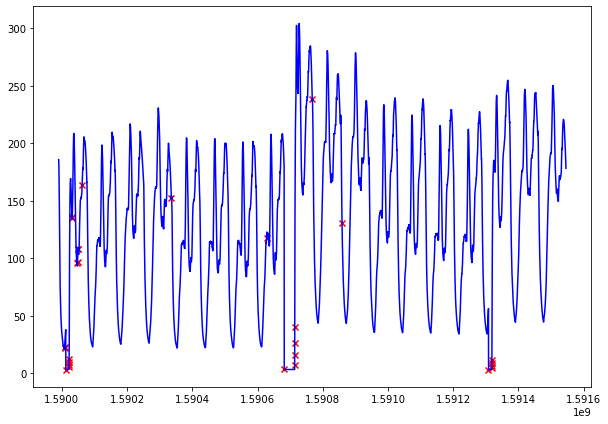

In [14]:
df_series = pd.read_csv('./data/train/0')
df_series['time'] = df_series['time'].apply(lambda x: int(datetime.strptime(x, '%Y-%m-%d %H:%M:%S').timestamp()))
df_series['id'] = range(len(df_series))
df_alert = df_series[df_series['alert_flag'] == 1]
# print(df_alert)
plt.figure(figsize=(10, 7))
plt.plot(df_series['time'], df_series['value'], color='blue')
plt.scatter(df_alert['time'], df_alert['value'], marker='x', color='red')
plt.show()

In [15]:
timestamp, values, labels = df_series['time'], df_series['value'], df_series['alert_flag']
timestamp, missing, (values, labels) = complete_timestamp(timestamp, (values, labels))

# split the training and testing data
# test_portion = 0.3
# test_n = int(len(values) * test_portion)
# train_values, test_values = values[:-test_n], values[-test_n:]
# train_labels, test_labels = labels[:-test_n], labels[-test_n:]
# train_missing, test_missing = missing[:-test_n], missing[-test_n:]

# test itself
test_n = int(len(values))
train_values, test_values = values, values
train_labels, test_labels = labels, labels
train_missing, test_missing = missing, missing

# standardize the training and testing data
train_values, mean, std = standardize_kpi(train_values, excludes=np.logical_or(train_labels, train_missing))
test_values, _, _ = standardize_kpi(test_values, mean=mean, std=std)
print(test_values)

[0.7674545  0.7615033  0.76068854 ... 0.6665314  0.66369754 0.656967  ]


In [16]:
with tf.variable_scope('model') as model_vs:
    model = Donut(
        h_for_p_x = Sequential([
            K.layers.Dense(100, kernel_regularizer=K.regularizers.l2(0.001), activation=tf.nn.relu),
            K.layers.Dense(100, kernel_regularizer=K.regularizers.l2(0.001), activation=tf.nn.relu)
        ]),
        h_for_q_z = Sequential([
            K.layers.Dense(100, kernel_regularizer=K.regularizers.l2(0.001), activation=tf.nn.relu),
            K.layers.Dense(100, kernel_regularizer=K.regularizers.l2(0.001), activation=tf.nn.relu)
        ]),
        x_dims = 120,
        z_dims = 5,
    )

In [17]:
save_dir = '.'

trainer = DonutTrainer(model=model, model_vs=model_vs)
predictor = DonutPredictor(model)

with tf.Session().as_default():
    trainer.fit(train_values, train_labels, train_missing, mean, std)
    test_score = predictor.get_score(test_values, test_missing)

    # # save and restore a trained model
    # var_dict = get_variables_as_dict(model_vs)
    # # save variables to `save_dir`
    # saver = VariableSaver(var_dict, save_dir)
    # saver.save()

    # fix test_score with brute force
    
    test_score = np.concatenate(([0 for i in range(119)], test_score))

Trainable Parameters                     (58,150 in total)
----------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (120,)         120
donut/p_x_given_z/x_mean/kernel         (100, 120)  12,000
donut/p_x_given_z/x_std/bias            (120,)         120
donut/p_x_given_z/x_std/kernel          (100, 120)  12,000
donut/q_z_given_x/z_mean/bias           (5,)             5
donut/q_z_given_x/z_mean/kernel         (100, 5)       500
donut/q_z_given_x/z_std/bias            (5,)             5
donut/q_z_given_x/z_std/kernel          (100, 5)       500
sequential/forward/_0/dense/bias        (100,)         100
sequential/forward/_0/dense/kernel      (5, 100)       500
sequential/forward/_1/dense_1/bias      (100,)         100
sequential/forward/_1/dense_1/kernel    (100, 100)  10,000
sequential_1/forward/_0/dense_2/bias    (100,)         100
sequential_1/forward/_0/dense_2/kernel  (120, 100)  12,000
sequential_1/forward/_1/dense_3/bias    (100,)         1

FailedPreconditionError: Error while reading resource variable model_1/sequential/forward/_1/dense_5/bias from Container: localhost. This could mean that the variable was uninitialized. Not found: Resource localhost/model_1/sequential/forward/_1/dense_5/bias/class tensorflow::Var does not exist.
	 [[node model_1/sequential/forward/_1/dense_5/BiasAdd/ReadVariableOp (defined at C:\Users\jemerycheng\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\ops.py:1748) ]]

Original stack trace for 'model_1/sequential/forward/_1/dense_5/BiasAdd/ReadVariableOp':
  File "C:\Users\jemerycheng\Anaconda3\envs\python37\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\jemerycheng\Anaconda3\envs\python37\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\jemerycheng\Anaconda3\envs\python37\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\jemerycheng\Anaconda3\envs\python37\lib\site-packages\traitlets\config\application.py", line 664, in launch_instance
    app.start()
  File "C:\Users\jemerycheng\Anaconda3\envs\python37\lib\site-packages\ipykernel\kernelapp.py", line 597, in start
    self.io_loop.start()
  File "C:\Users\jemerycheng\Anaconda3\envs\python37\lib\site-packages\tornado\platform\asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\jemerycheng\Anaconda3\envs\python37\lib\asyncio\base_events.py", line 541, in run_forever
    self._run_once()
  File "C:\Users\jemerycheng\Anaconda3\envs\python37\lib\asyncio\base_events.py", line 1786, in _run_once
    handle._run()
  File "C:\Users\jemerycheng\Anaconda3\envs\python37\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\jemerycheng\Anaconda3\envs\python37\lib\site-packages\tornado\ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "C:\Users\jemerycheng\Anaconda3\envs\python37\lib\site-packages\tornado\ioloop.py", line 743, in _run_callback
    ret = callback()
  File "C:\Users\jemerycheng\Anaconda3\envs\python37\lib\site-packages\tornado\gen.py", line 787, in inner
    self.run()
  File "C:\Users\jemerycheng\Anaconda3\envs\python37\lib\site-packages\tornado\gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "C:\Users\jemerycheng\Anaconda3\envs\python37\lib\site-packages\ipykernel\kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\jemerycheng\Anaconda3\envs\python37\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\jemerycheng\Anaconda3\envs\python37\lib\site-packages\ipykernel\kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\jemerycheng\Anaconda3\envs\python37\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\jemerycheng\Anaconda3\envs\python37\lib\site-packages\ipykernel\kernelbase.py", line 545, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\jemerycheng\Anaconda3\envs\python37\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\jemerycheng\Anaconda3\envs\python37\lib\site-packages\ipykernel\ipkernel.py", line 300, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\jemerycheng\Anaconda3\envs\python37\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\jemerycheng\Anaconda3\envs\python37\lib\site-packages\IPython\core\interactiveshell.py", line 2858, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\jemerycheng\Anaconda3\envs\python37\lib\site-packages\IPython\core\interactiveshell.py", line 2886, in _run_cell
    return runner(coro)
  File "C:\Users\jemerycheng\Anaconda3\envs\python37\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\jemerycheng\Anaconda3\envs\python37\lib\site-packages\IPython\core\interactiveshell.py", line 3063, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\jemerycheng\Anaconda3\envs\python37\lib\site-packages\IPython\core\interactiveshell.py", line 3254, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "C:\Users\jemerycheng\Anaconda3\envs\python37\lib\site-packages\IPython\core\interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-614cd4f615d4>", line 3, in <module>
    trainer = DonutTrainer(model=model, model_vs=model_vs)
  File "C:\Users\jemerycheng\Anaconda3\envs\python37\lib\site-packages\donut\training.py", line 126, in __init__
    x=self._input_x, y=self._input_y, n_z=n_z)
  File "C:\Users\jemerycheng\Anaconda3\envs\python37\lib\site-packages\donut\model.py", line 142, in get_training_loss
    chain = self.vae.chain(x, n_z=n_z)
  File "C:\Users\jemerycheng\Anaconda3\envs\python37\lib\site-packages\tfsnippet\modules\auto_encoders\vae.py", line 374, in chain
    observed={'x': x}
  File "C:\Users\jemerycheng\Anaconda3\envs\python37\lib\site-packages\tfsnippet\bayes.py", line 378, in variational_chain
    model_and_log_joint = model_builder(merged_obs, **kwargs)
  File "C:\Users\jemerycheng\Anaconda3\envs\python37\lib\site-packages\tfsnippet\modules\auto_encoders\vae.py", line 372, in <lambda>
    lambda observed: self.model(n_z=n_z, n_x=None, **observed),
  File "C:\Users\jemerycheng\Anaconda3\envs\python37\lib\site-packages\tfsnippet\utils\reuse.py", line 179, in wrapper
    return method(*args, **kwargs)
  File "C:\Users\jemerycheng\Anaconda3\envs\python37\lib\site-packages\tfsnippet\modules\auto_encoders\vae.py", line 314, in model
    x_params = self.h_for_p_x(z)
  File "C:\Users\jemerycheng\Anaconda3\envs\python37\lib\site-packages\tfsnippet\modules\base.py", line 89, in __call__
    return self._forward(inputs, **kwargs)
  File "C:\Users\jemerycheng\Anaconda3\envs\python37\lib\site-packages\tfsnippet\modules\container\lambda_.py", line 47, in _forward
    return self._factory(inputs, **kwargs)
  File "C:\Users\jemerycheng\Anaconda3\envs\python37\lib\site-packages\donut\model.py", line 24, in wrap_params_net
    h = h_for_dist(inputs)
  File "C:\Users\jemerycheng\Anaconda3\envs\python37\lib\site-packages\tfsnippet\modules\base.py", line 89, in __call__
    return self._forward(inputs, **kwargs)
  File "C:\Users\jemerycheng\Anaconda3\envs\python37\lib\site-packages\tfsnippet\modules\container\sequential.py", line 78, in _forward
    outputs = c(outputs)
  File "C:\Users\jemerycheng\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\keras\engine\base_layer.py", line 854, in __call__
    outputs = call_fn(cast_inputs, *args, **kwargs)
  File "C:\Users\jemerycheng\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\keras\layers\core.py", line 1052, in call
    outputs = nn.bias_add(outputs, self.bias)
  File "C:\Users\jemerycheng\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\ops\nn_ops.py", line 2717, in bias_add
    bias = ops.convert_to_tensor(bias, dtype=value.dtype, name="bias")
  File "C:\Users\jemerycheng\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\ops.py", line 1184, in convert_to_tensor
    return convert_to_tensor_v2(value, dtype, preferred_dtype, name)
  File "C:\Users\jemerycheng\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\ops.py", line 1242, in convert_to_tensor_v2
    as_ref=False)
  File "C:\Users\jemerycheng\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\ops.py", line 1297, in internal_convert_to_tensor
    ret = conversion_func(value, dtype=dtype, name=name, as_ref=as_ref)
  File "C:\Users\jemerycheng\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\ops\resource_variable_ops.py", line 1789, in _dense_var_to_tensor
    return var._dense_var_to_tensor(dtype=dtype, name=name, as_ref=as_ref)  # pylint: disable=protected-access
  File "C:\Users\jemerycheng\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\ops\resource_variable_ops.py", line 1214, in _dense_var_to_tensor
    return self.value()
  File "C:\Users\jemerycheng\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\ops\resource_variable_ops.py", line 524, in value
    return self._read_variable_op()
  File "C:\Users\jemerycheng\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\ops\resource_variable_ops.py", line 608, in _read_variable_op
    self._dtype)
  File "C:\Users\jemerycheng\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\ops\gen_resource_variable_ops.py", line 586, in read_variable_op
    "ReadVariableOp", resource=resource, dtype=dtype, name=name)
  File "C:\Users\jemerycheng\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\op_def_library.py", line 794, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\jemerycheng\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\Users\jemerycheng\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\ops.py", line 3357, in create_op
    attrs, op_def, compute_device)
  File "C:\Users\jemerycheng\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\ops.py", line 3426, in _create_op_internal
    op_def=op_def)
  File "C:\Users\jemerycheng\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\ops.py", line 1748, in __init__
    self._traceback = tf_stack.extract_stack()


value        time  alert_flag     id
301     22.390133  1590008460           1    301
302     22.993158  1590008520           1    302
360      3.469657  1590012000           1    360
528      5.288376  1590022260           1    528
529      7.753538  1590022320           1    529
530     10.247644  1590022380           1    530
531     12.845471  1590022440           1    531
689    135.271380  1590031920           1    689
690    135.850280  1590031980           1    690
958     95.614110  1590048060           1    958
959     96.673030  1590048120           1    959
990    108.407870  1590049980           1    990
991    107.763840  1590050040           1    991
1198   163.837830  1590062460           1   1198
5719   152.756650  1590336060           1   5719
10580  118.015240  1590627720           1  10580
11478    3.476893  1590681600           1  11478
12007    7.237349  1590713880           1  12007
12008   16.386427  1590713940           1  12008
12009   26.418333  1590714000   

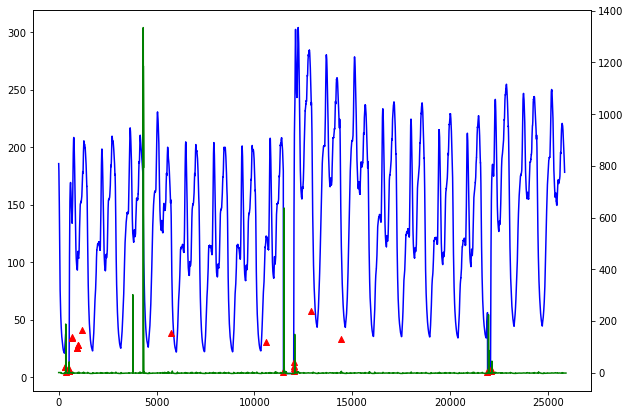

In [19]:
# plot
fig = plt.figure(figsize=(10, 7))
# subplot 1
ax1 = fig.add_subplot(111)
df_value = df_series[['value']]
df_value['id'] = range(len(df_value))
df_value.set_index('id')
ax1.plot(df_value['id'], df_value['value'], color='blue')
# subplot 2
df_test_score = pd.DataFrame({'score': test_score*(-1)})
df_test_score['id'] = range(len(df_test_score))
# df_test_score = df_test_score[df_test_score['score'] >= 300]
ax2 = ax1.twinx()
ax2.plot(df_test_score['id'], df_test_score['score'], color='green')
df_test_score = df_test_score[df_test_score['score'] >= 50]
# print(df_test_score)

print(df_alert)
plt.scatter(df_alert['id'], df_alert['value'], marker='^', color='red')
# ax2.scatter(df_test_score['id'], df_test_score['score'], color='black', marker='^')
# ax1.plot(test_values)
# ax1.set_ylabel('test_values')
# ax2 = ax1.twinx()
# ax2.plot(test_score*-1, 'r-')
# ax2.set_ylabel('test_scores', color='r')
# for i in ax2.get_yticklabels():
#     i.set_color('r')
# ax3 = ax1.twinx()
# ax3.scatter(df_alert, marker='x', color='black')
plt.show()